# HAP1 cancer, 41 clones, newOpera, arrayed format - retrain model without mixed clones FOV
- some FOVs unfortunately contain  mix of clones instead of just 1
- went through all -> marked those to discard from training dataset

In [1]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

import os
import os.path
import json

import joblib

from functions.misc_utils import get_well_ID, show_whole_df, move_columns_to_front

from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Config

In [27]:
merged_cp_measurements_path = "/nobackup/lab_kubicek/jreinis/2023-02-17_41clones_newOpera_check/RF_models_train/HAP1_41_clones_arrayed_newOpera_cellprofiler_merged.pickle"
mixed_FOVs_metadata_path = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/HAP1_cancer_41clones_arrayed_newOpera_FOVs_mix_with_metadata.csv"

features_in_complete_path = "/home/jreinis/saved_models/2023-02-20_rf_model_cellprofiler_features_in_complete.npy"

merged_cp_measurements_NOMIX_savepath = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/HAP1_41_clones_arrayed_newOpera_cellprofiler_merged_noMIX.pickle"

rf_subset_outfolder = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_plates_measurements_separate"
rf_final_outfolder = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final"

confusion_matrix_savepath = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/confusion_matrix/mean_cf_matrix_settings.pdf"
result_settings_savepath = "/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/confusion_matrix/results_settings.csv"

savepath_figuredata_cf_mean = "/nobackup/lab_kubicek/jreinis/2023-10-17_manuscript_figures_source_data/fig3_confusion_matrix_mean.csv"
savepath_figuredata_cf_settings = "/nobackup/lab_kubicek/jreinis/2023-10-17_manuscript_figures_source_data/fig3_confusion_matrix_all_settings.csv"

### Load data

In [4]:
features_in_complete = np.load(features_in_complete_path, allow_pickle=True)

In [5]:
merged_measurements = pd.read_pickle(merged_cp_measurements_path).sort_values(["plate", "measurement", "image", "ObjectNumber_cell"]).reset_index(drop=True)

In [6]:
merged_measurements

,image,row,column,FOV,ImageNumber_cell,ObjectNumber_cell,Location_Center_X_cell,Location_Center_Y_cell,Location_Center_X_nucleus,Location_Center_Y_nucleus,...,Texture_Variance_mScarlet_3_02_256_cytoplasm,Texture_Variance_mScarlet_3_03_256_cytoplasm,Texture_Variance_miRFP_3_00_256_cytoplasm,Texture_Variance_miRFP_3_01_256_cytoplasm,Texture_Variance_miRFP_3_02_256_cytoplasm,Texture_Variance_miRFP_3_03_256_cytoplasm,plate,measurement,well,clone
0,r02c09f01p01,2,9,1,1,1,643.999375,884.893608,644.283077,903.499487,...,5.216311,4.336165,0.936103,0.846892,0.882681,0.775378,plate1,measurement1,B09,F07
1,r02c09f01p01,2,9,1,1,2,911.981053,1017.541484,919.970218,1020.766380,...,2.085439,1.833829,0.587372,0.585012,0.612182,0.562155,plate1,measurement1,B09,F07
2,r02c09f01p01,2,9,1,1,3,838.709882,919.413600,829.510609,920.684963,...,1.294683,0.993562,0.668216,0.521631,0.530733,0.406497,plate1,measurement1,B09,F07
3,r02c09f01p01,2,9,1,1,4,709.682877,1008.766675,708.608027,996.447054,...,6.472020,5.955039,1.836962,1.603968,1.825724,1.758600,plate1,measurement1,B09,F07
4,r02c09f01p01,2,9,1,1,5,613.070441,952.932412,634.496481,951.239283,...,21.676602,15.853897,3.532917,3.919488,4.315249,3.279976,plate1,measurement1,B09,F07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496096,r08c06f49p01,8,6,49,2009,64,1005.061327,120.140592,1011.239965,128.427574,...,72.360575,65.770070,362.623603,401.351530,435.114435,396.276843,plate2,measurement2,H06,F07
496097,r08c06f49p01,8,6,49,2009,65,1044.625109,248.358049,1036.962025,257.094515,...,8.101571,6.418158,0.613451,0.590070,0.655578,0.576045,plate2,measurement2,H06,F07
496098,r08c06f49p01,8,6,49,2009,66,135.146573,429.834417,137.583790,422.168675,...,3.443809,2.401483,0.256687,0.252500,0.255903,0.250816,plate2,measurement2,H06,F07
496099,r08c06f49p01,8,6,49,2009,67,800.188793,794.835653,802.302239,790.300000,...,7.804695,7.960743,0.473816,0.420099,0.449029,0.422273,plate2,measurement2,H06,F07


In [7]:
mixed_FOVs_metadata = pd.read_csv(mixed_FOVs_metadata_path).drop_duplicates().reset_index(drop=True)
mixed_FOVs_metadata["plate"] = "plate" + mixed_FOVs_metadata["plate"].astype("str")
mixed_FOVs_metadata["measurement"] = "measurement" + mixed_FOVs_metadata["measurement"].astype("str")

### Discard cells from FOVs with mix of clones
- get index of cells from these FOVs
- then discard from dataset

In [7]:
cells_in_mix_FOVs = merged_measurements.reset_index()[["plate", "measurement", "image", "index"]].merge(mixed_FOVs_metadata[["plate", "measurement", "image"]], on=["plate", "measurement", "image"])

In [8]:
cells_in_mix_FOVs

,plate,measurement,image,index
0,plate1,measurement1,r03c06f10p01,7879
1,plate1,measurement1,r03c06f10p01,7880
2,plate1,measurement1,r03c06f10p01,7881
3,plate1,measurement1,r03c06f10p01,7882
4,plate1,measurement1,r03c06f10p01,7883
...,...,...,...,...
9015,plate2,measurement2,r08c05f09p01,490004
9016,plate2,measurement2,r08c05f09p01,490005
9017,plate2,measurement2,r08c05f09p01,490006
9018,plate2,measurement2,r08c05f09p01,490007


In [9]:
merged_measurements_nomix = merged_measurements.drop(index=cells_in_mix_FOVs["index"])

In [10]:
merged_measurements_nomix

,image,row,column,FOV,ImageNumber_cell,ObjectNumber_cell,Location_Center_X_cell,Location_Center_Y_cell,Location_Center_X_nucleus,Location_Center_Y_nucleus,...,Texture_Variance_mScarlet_3_02_256_cytoplasm,Texture_Variance_mScarlet_3_03_256_cytoplasm,Texture_Variance_miRFP_3_00_256_cytoplasm,Texture_Variance_miRFP_3_01_256_cytoplasm,Texture_Variance_miRFP_3_02_256_cytoplasm,Texture_Variance_miRFP_3_03_256_cytoplasm,plate,measurement,well,clone
0,r02c09f01p01,2,9,1,1,1,643.999375,884.893608,644.283077,903.499487,...,5.216311,4.336165,0.936103,0.846892,0.882681,0.775378,plate1,measurement1,B09,F07
1,r02c09f01p01,2,9,1,1,2,911.981053,1017.541484,919.970218,1020.766380,...,2.085439,1.833829,0.587372,0.585012,0.612182,0.562155,plate1,measurement1,B09,F07
2,r02c09f01p01,2,9,1,1,3,838.709882,919.413600,829.510609,920.684963,...,1.294683,0.993562,0.668216,0.521631,0.530733,0.406497,plate1,measurement1,B09,F07
3,r02c09f01p01,2,9,1,1,4,709.682877,1008.766675,708.608027,996.447054,...,6.472020,5.955039,1.836962,1.603968,1.825724,1.758600,plate1,measurement1,B09,F07
4,r02c09f01p01,2,9,1,1,5,613.070441,952.932412,634.496481,951.239283,...,21.676602,15.853897,3.532917,3.919488,4.315249,3.279976,plate1,measurement1,B09,F07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496096,r08c06f49p01,8,6,49,2009,64,1005.061327,120.140592,1011.239965,128.427574,...,72.360575,65.770070,362.623603,401.351530,435.114435,396.276843,plate2,measurement2,H06,F07
496097,r08c06f49p01,8,6,49,2009,65,1044.625109,248.358049,1036.962025,257.094515,...,8.101571,6.418158,0.613451,0.590070,0.655578,0.576045,plate2,measurement2,H06,F07
496098,r08c06f49p01,8,6,49,2009,66,135.146573,429.834417,137.583790,422.168675,...,3.443809,2.401483,0.256687,0.252500,0.255903,0.250816,plate2,measurement2,H06,F07
496099,r08c06f49p01,8,6,49,2009,67,800.188793,794.835653,802.302239,790.300000,...,7.804695,7.960743,0.473816,0.420099,0.449029,0.422273,plate2,measurement2,H06,F07


In [15]:
del merged_measurements

In [16]:
merged_measurements_nomix.to_pickle(merged_cp_measurements_NOMIX_savepath)

In [8]:
merged_measurements_nomix = pd.read_pickle(merged_cp_measurements_NOMIX_savepath)

## Train the random forest models

### Train and validate model on the different settings - all available features

In [10]:
validate_settings = [
    ["plate1", "measurement1"],
    ["plate1", "measurement2"],
    ["plate2", "measurement1"],
    ["plate2", "measurement2"],
]

#### Train models

In [8]:
for plate, measurement in tqdm(validate_settings[:]):
    rf_path = f'{rf_subset_outfolder}/{plate}_{measurement}_rf_model.joblib'
    
    train = merged_measurements_nomix.query(f'plate=="{plate}" & measurement=="{measurement}"')
    X_train = train[features_in_complete]
    y_train = train["clone"]
    
    rf = RandomForestClassifier(verbose=2,n_jobs=-1).fit(X_train, y_train)
    joblib.dump(rf, rf_path, compress=("lzma", 9))

  0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.1s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.5s finished
 25%|██▌       | 1/4 [01:00<03:02, 60.97s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.3s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
 50%|█████     | 2/4 [02:58<03:08, 94.32s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.0s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.9s finished
 75%|███████▌  | 3/4 [04:09<01:23, 83.64s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.4s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
100%|██████████| 4/4 [06:07<00:00, 91.85s/it]


In [17]:
merged_measurements_nomix.groupby("clone")["image"].count().reset_index()

,clone,image
0,A02,10808
1,A03,15221
2,A04,13976
3,A05,18071
4,A06,6645
5,A07,12338
6,B01,14172
7,B02,16515
8,B03,9806
9,B04,12540


#### Test and validate

In [14]:
result = []
mean_cf = np.zeros((41,41))
cm_percent_collector = []
cm_collector = []
f1_scores_collector = []


# for each measurement 
for train_plate, train_measurement in tqdm(validate_settings[:]):
    #print("TRAIN:", train_plate, train_measurement)
    rf_path = f'{rf_subset_outfolder}/{train_plate}_{train_measurement}_rf_model.joblib'
    rf = joblib.load(rf_path)
    rf.verbose = 0
    # report performance on all measurements
    for validate_plate, validate_measurement in validate_settings:
        #print("VALIDATE:", validate_plate, validate_measurement)
        # only validate on non-training measurements
        if train_plate+train_measurement == validate_plate+validate_measurement:
            continue
        # get predictions
        validate = merged_measurements_nomix.query(f'plate == "{validate_plate}" & measurement == "{validate_measurement}"')
        X_validate = validate[rf.feature_names_in_]
        y_validate = validate["clone"]
        y_pred = rf.predict(X_validate)
        
        # calculate scores based on f1
        f1_scores_clones = f1_score(y_validate, y_pred, average=None)
        f1_score_macro = f1_scores_clones.mean()
        f1_scores_min = f1_scores_clones.min()
        clone_f1_scores_min = rf.classes_[np.argmin(f1_scores_clones)]
        
        # calculate accuracy per clone
        cm_percent = confusion_matrix(y_validate, y_pred, labels=rf.classes_, normalize='true')
        cm_collector.append(confusion_matrix(y_validate, y_pred, labels=rf.classes_, normalize=None))
        accuracy = cm_percent.diagonal().mean()
        accuracy_min = cm_percent.diagonal().min()
        clone_accuracy_min = rf.classes_[np.argmin(cm_percent.diagonal())]
        
        result.append([train_plate, train_measurement, validate_plate, validate_measurement, f1_score_macro, f1_scores_min, clone_f1_scores_min, accuracy, accuracy_min, clone_accuracy_min])
        cm_percent_collector.append(cm_percent)
        f1_scores_collector.append(f1_scores_clones)
        mean_cf += cm_percent
        
        
        A03_idx = rf.classes_ == "A03"
        E07_idx = rf.classes_ == "E07"

        #print(cm_percent[A03_idx,A03_idx])
        #print(cm_percent[A03_idx,E07_idx])
        #print(cm_percent[E07_idx,A03_idx])
        #print(cm_percent[E07_idx,E07_idx])
        #print()
        
mean_cf /= len(result)

100%|██████████| 4/4 [00:53<00:00, 13.46s/it]


### Plot the mean confusion matrix

In [ ]:
mean_cf = pd.DataFrame(mean_cf, columns=rf.classes_, index=rf.classes_)
mean_cf

,A02,A03,A04,A05,A06,A07,B01,B02,B03,B04,...,E05,E06,E07,F01,F02,F03,F04,F05,F06,F07
A02,0.979218,0.000068,0.014977,0.000068,0.000000,0.000000,0.000487,0.000000,0.000000,0.000000,...,0.000000,0.000020,0.000000,0.000000,0.000079,0.000167,0.000023,0.000000,0.000000,0.001364
A03,0.000000,0.981765,0.000046,0.006565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001701,0.000045,0.001902,0.000169,0.000045,0.000089,0.000223,0.000000,0.000000,0.000000
A04,0.009564,0.000860,0.985611,0.000223,0.000092,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000036,0.000434,0.000000,0.000037,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
A05,0.000000,0.012893,0.000013,0.960891,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,...,0.000497,0.000000,0.000546,0.000000,0.000052,0.000000,0.000000,0.000000,0.000124,0.000000
A06,0.000288,0.000000,0.000000,0.000000,0.969399,0.000040,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000191,0.000000,0.000139,0.000000,0.000000,0.000000,0.001024,0.000000,0.000000
A07,0.000000,0.000000,0.000000,0.000000,0.000000,0.986400,0.000000,0.000455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B01,0.000506,0.000000,0.000060,0.000000,0.000000,0.000000,0.998096,0.000000,0.000066,0.000000,...,0.000000,0.000030,0.000000,0.000000,0.000000,0.000000,0.000060,0.000000,0.000000,0.000000
B02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992795,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000044,0.000036,0.000000,0.000205,0.000036,0.000000,0.000000
B03,0.000202,0.000000,0.000000,0.000000,0.000000,0.000000,0.001509,0.000000,0.997063,0.000000,...,0.000000,0.000389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000242,0.000000
B04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999180,...,0.000019,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000,0.000000,0.000000


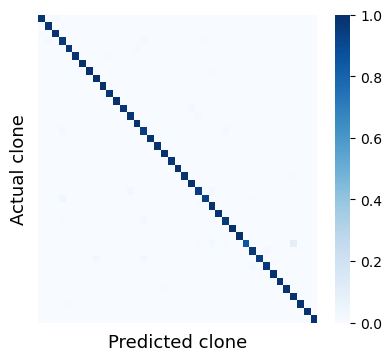

In [18]:
plt.figure(figsize=(4.5,4))
sns.heatmap(mean_cf, cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_, vmax=1, linecolor="white", linewidths=0)
plt.xlabel('Predicted clone', fontsize = 13)
plt.ylabel('Actual clone', fontsize = 13)
plt.xticks([], [])
plt.yticks([], [])
plt.savefig(confusion_matrix_savepath, bbox_inches="tight")
plt.show()

In [32]:
mean_cf_save = mean_cf.copy()
mean_cf_save.index.name = "actual_clone"
#upper_level_columns = pd.MultiIndex.from_product([['predicted_clone'], mean_cf_save.columns])
#mean_cf_save.columns = upper_level_columns
mean_cf_save.to_csv(savepath_figuredata_cf_mean)
mean_cf_save

,A02,A03,A04,A05,A06,A07,B01,B02,B03,B04,...,E05,E06,E07,F01,F02,F03,F04,F05,F06,F07
actual_clone,,,,,,,,,,,,,,,,,,,,,
A02,0.979218,0.000068,0.014977,0.000068,0.000000,0.000000,0.000487,0.000000,0.000000,0.000000,...,0.000000,0.000020,0.000000,0.000000,0.000079,0.000167,0.000023,0.000000,0.000000,0.001364
A03,0.000000,0.981765,0.000046,0.006565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001701,0.000045,0.001902,0.000169,0.000045,0.000089,0.000223,0.000000,0.000000,0.000000
A04,0.009564,0.000860,0.985611,0.000223,0.000092,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000036,0.000434,0.000000,0.000037,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
A05,0.000000,0.012893,0.000013,0.960891,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,...,0.000497,0.000000,0.000546,0.000000,0.000052,0.000000,0.000000,0.000000,0.000124,0.000000
A06,0.000288,0.000000,0.000000,0.000000,0.969399,0.000040,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000191,0.000000,0.000139,0.000000,0.000000,0.000000,0.001024,0.000000,0.000000
A07,0.000000,0.000000,0.000000,0.000000,0.000000,0.986400,0.000000,0.000455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B01,0.000506,0.000000,0.000060,0.000000,0.000000,0.000000,0.998096,0.000000,0.000066,0.000000,...,0.000000,0.000030,0.000000,0.000000,0.000000,0.000000,0.000060,0.000000,0.000000,0.000000
B02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992795,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000044,0.000036,0.000000,0.000205,0.000036,0.000000,0.000000
B03,0.000202,0.000000,0.000000,0.000000,0.000000,0.000000,0.001509,0.000000,0.997063,0.000000,...,0.000000,0.000389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000242,0.000000


### Scores for each setting

In [19]:
settings_scores = pd.DataFrame(np.array(result))
settings_scores.columns = ["train_plate", "train_measurement", "validate_plate", "validate_measurement", "f1_score_macro", "f1_clones_min", "clone_f1_scores_min", "accuracy_avg", "accuracy_clones_min", "clone_accuracy_min"]
settings_scores.to_csv(result_settings_savepath, index=None)
settings_scores["training_set"] = settings_scores["train_plate"] + "_" + settings_scores["train_measurement"]
settings_scores["validation_set"] = settings_scores["validate_plate"] + "_" + settings_scores["validate_measurement"]
settings_scores = settings_scores[["training_set", "validation_set", "f1_score_macro", "f1_clones_min", "clone_f1_scores_min", "accuracy_avg", "accuracy_clones_min", "clone_accuracy_min"]]
settings_scores

,training_set,validation_set,f1_score_macro,f1_clones_min,clone_f1_scores_min,accuracy_avg,accuracy_clones_min,clone_accuracy_min
0,plate1_measurement1,plate1_measurement2,0.9714332854920951,0.7321428571428572,E04,0.9703388553978995,0.5857142857142857,E04
1,plate1_measurement1,plate2_measurement1,0.9906332824287474,0.9743589743589743,E04,0.990095640920962,0.95,E04
2,plate1_measurement1,plate2_measurement2,0.9791571354641553,0.8823191733639494,C03,0.981202572612545,0.8722457155575339,E01
3,plate1_measurement2,plate1_measurement1,0.968377140243909,0.8256880733944955,E04,0.9665232517870258,0.7820085673488815,D05
4,plate1_measurement2,plate2_measurement1,0.971195684660638,0.8833333333333333,E04,0.9697077829173272,0.847718253968254,C03
5,plate1_measurement2,plate2_measurement2,0.9956627285262797,0.9814770267019485,A06,0.9955026551620367,0.9793566970715314,A06
6,plate2_measurement1,plate1_measurement1,0.9913853974369599,0.9739600946905647,E05,0.9910090175226649,0.9619238476953907,E05
7,plate2_measurement1,plate1_measurement2,0.976951334407631,0.7387387387387387,E04,0.9750156795434812,0.5857142857142857,E04
8,plate2_measurement1,plate2_measurement2,0.9836612666797415,0.9251075189084976,C03,0.9853609341759261,0.9234575087310827,D04
9,plate2_measurement2,plate1_measurement1,0.9684376653438637,0.8590021691973969,D05,0.9658627126454048,0.7539267015706806,D05


In [143]:
settings_scores.to_csv("/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/supl_tables/arrayed_training_sets_settings_scores.csv", index=None)

### Get cell counts for each clone and train setting

In [91]:
cell_counts_training_datasets = merged_measurements_nomix[["plate", "measurement", "clone"]].value_counts().rename("n_cells").reset_index().sort_values(["plate", "measurement", "clone"])
cell_counts_training_datasets = cell_counts_training_datasets.pivot(index=["plate", "measurement"], columns="clone", values="n_cells")#.droplevel(1, axis=1)
cell_counts_training_datasets.columns.name = None
cell_counts_training_datasets = cell_counts_training_datasets.reset_index()
cell_counts_training_datasets["row_sum"] = cell_counts_training_datasets.iloc[:,2:].sum(axis=1)
with pd.option_context("display.max_columns", 50):
    display(cell_counts_training_datasets)

,plate,measurement,A02,A03,A04,A05,A06,A07,B01,B02,B03,B04,B05,B06,B07,C01,C02,C03,C04,C05,C06,C07,D01,D02,D03,D04,D05,D06,D07,E01,E02,E03,E04,E05,E06,E07,F01,F02,F03,F04,F05,F06,F07,row_sum
0,plate1,measurement1,1229,1870,2152,2734,1182,2144,2548,2352,1704,2297,988,1645,1981,2144,1697,2563,2104,1764,1497,1404,1809,2457,1779,2129,2101,2436,2537,2726,1627,2064,53,1497,687,2353,835,1455,1844,2888,1882,1601,1003,75762
1,plate1,measurement2,4215,5632,4860,6391,1701,3453,4164,5469,3317,4287,1923,4813,5596,5252,2912,3552,4186,4973,3333,2873,4734,5456,3069,3405,3774,4587,4760,4494,5445,4951,70,4607,481,6302,2693,3631,2298,4319,3445,4206,1721,161350
2,plate2,measurement1,1693,2383,2507,2066,1679,2562,2755,2335,2064,2241,1285,2225,2691,2829,2907,2016,3063,2188,1712,1761,1910,2684,2062,2282,2766,2384,2559,2553,2011,2433,60,1702,650,3411,1616,2386,1396,2828,1899,1443,1525,87522
3,plate2,measurement2,3671,5336,4457,6880,2083,4179,4705,6359,2721,3715,2136,4700,5513,6024,4025,3172,4090,5931,2867,2177,5287,4461,2610,3436,5052,5801,4150,4493,5028,4681,90,4965,659,4051,3037,3245,1974,4509,3592,4140,2445,162447


In [135]:
cell_counts_training_datasets.to_csv("/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/supl_tables/cell_counts_training_datasets.csv", index=None)

### Get f-scores for each clone and train-validation setting

In [20]:
import itertools
val_sets = [x[0]+"_"+x[1] for x in validate_settings]
val_sets_annot = pd.DataFrame([x for x in list(itertools.product(val_sets, val_sets)) if x[0]!=x[1]], columns=["training_set", "validation_set"])

In [21]:
fscores_settings = pd.concat([val_sets_annot, pd.DataFrame(np.stack(f1_scores_collector), columns=rf.classes_)], axis=1)
fscores_settings["row_sum"] = fscores_settings.iloc[:,2:].sum(axis=1)
fscores_settings

,training_set,validation_set,A02,A03,A04,A05,A06,A07,B01,B02,...,E06,E07,F01,F02,F03,F04,F05,F06,F07,row_sum
0,plate1_measurement1,plate1_measurement2,0.987485,0.978981,0.988892,0.954828,0.985363,0.994061,0.999400,0.992887,...,0.848849,0.962507,0.995556,0.988773,0.994355,0.987955,0.995484,0.989116,0.992481,39.828765
1,plate1_measurement1,plate2_measurement1,0.988152,0.987587,0.991630,0.981450,0.986975,0.991778,0.997641,0.995929,...,0.993837,0.988163,0.991272,0.997065,0.992476,0.991881,0.996312,0.991059,0.992457,40.615965
2,plate1_measurement1,plate2_measurement2,0.984424,0.980530,0.989257,0.967794,0.971606,0.995208,0.999362,0.997017,...,0.885757,0.978485,0.995722,0.984527,0.996215,0.987217,0.995528,0.982843,0.991216,40.145443
3,plate1_measurement2,plate1_measurement1,0.979491,0.961338,0.987254,0.896052,0.954306,0.986068,0.996466,0.991264,...,0.945594,0.958661,0.992173,0.984006,0.984903,0.976473,0.994670,0.992453,0.989970,39.703463
4,plate1_measurement2,plate2_measurement1,0.976312,0.974115,0.979656,0.886784,0.953884,0.983769,0.996192,0.988432,...,0.967640,0.974551,0.987539,0.993467,0.984482,0.978135,0.993946,0.990264,0.985747,39.819023
5,plate1_measurement2,plate2_measurement2,0.995496,0.993512,0.997422,0.994198,0.981477,0.999043,0.999787,0.999292,...,0.993166,0.987552,0.997527,0.999538,0.999494,0.997336,0.998329,0.998429,0.996931,40.822172
6,plate2_measurement1,plate1_measurement1,0.992254,0.987641,0.995582,0.988089,0.988255,0.994857,0.998428,0.995112,...,0.995620,0.984880,0.991617,0.990331,0.991271,0.991515,0.996001,0.995946,0.992040,40.646801
7,plate2_measurement1,plate1_measurement2,0.973871,0.986064,0.976964,0.959032,0.977240,0.996531,0.999760,0.996977,...,0.937178,0.976793,0.990974,0.993944,0.994557,0.990613,0.989146,0.994025,0.994220,40.055005
8,plate2_measurement1,plate2_measurement2,0.973723,0.986923,0.979279,0.969494,0.967152,0.997609,0.999681,0.998584,...,0.948237,0.984794,0.994751,0.996009,0.996965,0.994320,0.985458,0.992346,0.993677,40.330112
9,plate2_measurement2,plate1_measurement1,0.964077,0.953886,0.980311,0.894963,0.950934,0.982722,0.995678,0.978247,...,0.950720,0.969451,0.989740,0.970785,0.980695,0.963429,0.997072,0.995622,0.993000,39.705944


In [136]:
fscores_settings.to_csv("/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/supl_tables/arrayed_benchmark_fscores_list.csv", index=None)

### Generate and save a confusion matrix for each train-validation setting

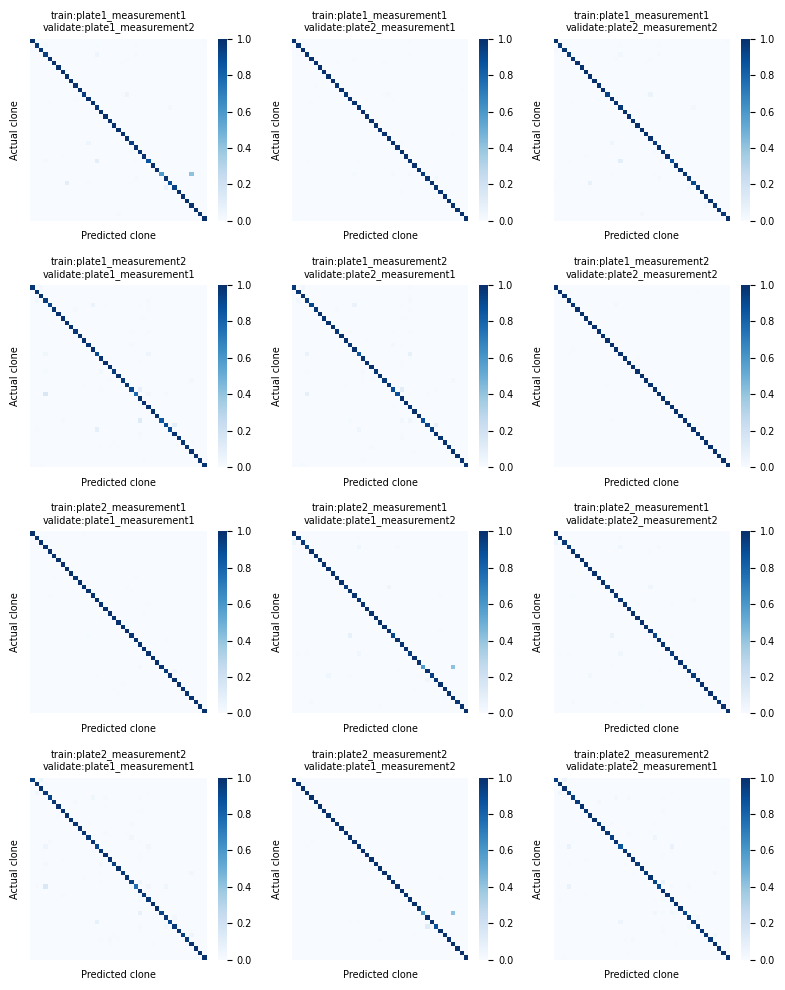

In [131]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 10))

for i, cm in enumerate(cm_percent_collector):
    ax = axes[i // 3, i % 3]
    sns.heatmap(cm, cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_, vmax=1, linecolor="white", linewidths=0, ax=ax)
    ax.set_xlabel('Predicted clone', fontsize=7)
    ax.set_ylabel('Actual clone', fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=7)
    train_set, valid_set = val_sets_annot.loc[i, ["training_set", "validation_set"]]
    ax.set_title(f"train:{train_set}\nvalidate:{valid_set}", fontsize=7)

plt.tight_layout()
plt.savefig("/nobackup/lab_kubicek/jreinis/2023-06-30_plots_images_paper/confusion_matrices_array_all_settings/cms_array_all.pdf", bbox_inches="tight")
plt.show()

In [97]:
cm_melted_collector = []
for i, (cm, cm_percent) in enumerate(zip(cm_collector, cm_percent_collector)):
    cm_setting = pd.DataFrame(cm, columns=rf.classes_, index=rf.classes_).reset_index().rename(columns={"index":"actual_clone"})
    cm_setting["train_setting"] = settings_scores.loc[i, "training_set"]
    cm_setting["validation_setting"] = settings_scores.loc[i, "validation_set"]
    cm_setting = cm_setting.melt(id_vars=["train_setting", "validation_setting", "actual_clone"], value_vars = rf.classes_, var_name = "predicted_clone", value_name="cells")
    
    cm_percent_setting = pd.DataFrame(cm_percent, columns=rf.classes_, index=rf.classes_).reset_index().rename(columns={"index":"actual_clone"})
    cm_percent_setting["train_setting"] = settings_scores.loc[i, "training_set"]
    cm_percent_setting["validation_setting"] = settings_scores.loc[i, "validation_set"]
    cm_percent_setting = cm_percent_setting.melt(id_vars=["train_setting", "validation_setting", "actual_clone"], value_vars = rf.classes_, var_name = "predicted_clone", value_name="predicted_percent_of_actual")
    
    cm_melted_collector.append(cm_setting.merge(cm_percent_setting, on=["train_setting", "validation_setting", "actual_clone", "predicted_clone"]))


In [98]:
predictions_settings_counts = pd.concat(cm_melted_collector)
predictions_settings_counts.to_csv(savepath_figuredata_cf_settings)
predictions_settings_counts

,train_setting,validation_setting,actual_clone,predicted_clone,cells,predicted_percent_of_actual
0,plate1_measurement1,plate1_measurement2,A02,A02,4182,0.992171
1,plate1_measurement1,plate1_measurement2,A03,A02,0,0.000000
2,plate1_measurement1,plate1_measurement2,A04,A02,67,0.013786
3,plate1_measurement1,plate1_measurement2,A05,A02,0,0.000000
4,plate1_measurement1,plate1_measurement2,A06,A02,1,0.000588
...,...,...,...,...,...,...
1676,plate2_measurement2,plate2_measurement1,F03,F07,0,0.000000
1677,plate2_measurement2,plate2_measurement1,F04,F07,0,0.000000
1678,plate2_measurement2,plate2_measurement1,F05,F07,0,0.000000
1679,plate2_measurement2,plate2_measurement1,F06,F07,0,0.000000


In [15]:
# for each setting its name and regexp used to filter out columns to discard
channels_settings = {
    "all": None,
    "all_but_GFP": "GFP",
    "all_but_mScarlet": "mScarlet",
    "BFP_structural": "GFP|mScarlet",
    "BFP_only": "GFP|mScarlet|mAmetrine|miRFP",
}

In [16]:
%%time
for setting, features_regex in tqdm(channels_settings.items()):
    if features_regex:
        features_selected = [x for x in features_in_complete if not re.search(features_regex, x)]
    else:
        features_selected = features_in_complete
    savepath = f"{rf_final_outfolder}/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_{setting}.joblib"
    print(setting, len(features_selected))
    print(savepath)
    print()
    
    X_train = merged_measurements_nomix[features_selected]
    y_train = merged_measurements_nomix["clone"]

    rf = RandomForestClassifier(verbose=2, n_jobs=-1).fit(X_train, y_train)
    joblib.dump(rf, savepath, compress=("lzma", 9))

  0%|          | 0/5 [00:00<?, ?it/s]

all 1455
/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_all.joblib



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished
 20%|██        | 1/5 [09:58<39:55, 598.85s/it]

all_but_GFP 1134
/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_all_but_GFP.joblib



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
 40%|████      | 2/5 [21:12<32:07, 642.59s/it]

all_but_mScarlet 1134
/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_all_but_mScarlet.joblib



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished
 60%|██████    | 3/5 [31:45<21:16, 638.49s/it]

BFP_structural 828
/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_BFP_structural.joblib



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.5min finished
 80%|████████  | 4/5 [46:03<12:05, 725.27s/it]

BFP_only 261
/nobackup/lab_kubicek/jreinis/2023-03-28_41clones_newOpera_train_RF_models_no_mixed_FOVs/RF_models_final/2023-03-28_HAP1_cancer_41_clones_newOpera_nomix_BFP_only.joblib



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
100%|██████████| 5/5 [1:07:05<00:00, 805.06s/it]

CPU times: user 5h 21min 3s, sys: 9.88 s, total: 5h 21min 12s
Wall time: 1h 7min 5s
